# ***Voorspellen van Verhuuraantallen*** 

Teamleden:
- Busse Heemskerk
- Declan van den Hoek
- Isa Dijkstra

In dit notebook worden er, aan de hand van een train dataset, verschillende Machine Learning modellen opgesteld om de meest accurate manier te vinden om diabetes te voorspellen. Voor het project hebben we gewerkt in [GitHub](https://github.com/BJHeemskerk/MachineLearning), om makkelijk de bestanden te delen.

## ***Inhoudsopgave*** <a name='begin'></a>

1. [H1: Explorative Data Analysis](#h1)

In [2]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

data_test = pd.read_csv('test.csv', sep = ',')
data_train = pd.read_csv('train.csv', sep = ',')

In [3]:
data_train.head()

,date_hour,holiday,weathersit,temp,atemp,hum,windspeed,cnt
0,2011-01-01 00:00:00,0,1,0.24,0.2879,0.81,0.0,16
1,2011-01-01 01:00:00,0,1,0.22,0.2727,0.80,0.0,40
2,2011-01-01 02:00:00,0,1,0.22,0.2727,0.80,0.0,32
3,2011-01-01 03:00:00,0,1,0.24,0.2879,0.75,0.0,13
4,2011-01-01 04:00:00,0,1,0.24,0.2879,0.75,0.0,1


## **H1: Explorative Data Analysis**<a name='h1'></a>

De minimale vereisten voor Machine Learning met Scikit Learn zijn:

- De data mag geen missende waardes hebben
- De data moet bestaan uit numerieke waardes
- De data moet in een dataframe staan

Omdat de data is ingelezen via Pandas staat het al in een Pandas DataFrame, hierdoor kan gebruik gemaakt worden van de .info() methode van DataFrames om te kijken naar missende waarden en de datatypen.

In [4]:
data_train.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 16637 entries, 0 to 16636
Data columns (total 8 columns):
 #   Column      Non-Null Count  Dtype  
---  ------      --------------  -----  
 0   date_hour   16637 non-null  object 
 1   holiday     16637 non-null  int64  
 2   weathersit  16637 non-null  int64  
 3   temp        16637 non-null  float64
 4   atemp       16637 non-null  float64
 5   hum         16637 non-null  float64
 6   windspeed   16637 non-null  float64
 7   cnt         16637 non-null  int64  
dtypes: float64(4), int64(3), object(1)
memory usage: 1.0+ MB


In [5]:
data_train.describe()

,holiday,weathersit,temp,atemp,hum,windspeed,cnt
count,16637.000000,16637.000000,16637.000000,16637.000000,16637.000000,16637.000000,16637.000000
mean,0.028671,1.415580,0.504745,0.482608,0.624756,0.190310,190.477009
std,0.166885,0.637298,0.192369,0.171557,0.193227,0.121915,182.026755
min,0.000000,1.000000,0.020000,0.000000,0.000000,0.000000,1.000000
25%,0.000000,1.000000,0.340000,0.333300,0.470000,0.104500,41.000000
50%,0.000000,1.000000,0.520000,0.500000,0.620000,0.194000,143.000000
75%,0.000000,2.000000,0.660000,0.621200,0.780000,0.253700,282.000000
max,1.000000,4.000000,1.000000,1.000000,1.000000,0.850700,977.000000


### ***Time-Series visualisaties***

Eerst zullen er de benodigde functies worden aangemaakt, om op die manier gemakkelijk de verschillende nieuwe time-series kolommen aan te maken.

In [6]:
def data_voorbereiding(base_df, dt_kol):
    """
    Een functie om een csv in te lezen en verschillende
    toepassingen uit te voeren op aanwezige timeseries
    data.

    Parameters:
    ----------
    base_df : pd.DataFrame
        De naam van het dataframe waar de extra
        timeseries kolommen worden gemaakt.
    
    dt_kol : str
        De naam van de kolom met de Timeseries data.

    Returns:
    ----------
    df : pd.DataFrame
        Een pandas.DataFrame waarin verschillende extra
        kolommen zijn toegevoegd waarin timeseries is
        toegepast.
    """
    
    # Omzetten van date_hour naar datetime
    df = base_df.copy()
    df[f'{dt_kol}'] = pd.to_datetime(df[f'{dt_kol}'])

    # Voeg nieuwe kolommen toe
    df['Jaar'] = df[f'{dt_kol}'].dt.year.astype(int)
    df['Maand'] = df[f'{dt_kol}'].dt.month.astype(int)
    df['Week'] = df[f'{dt_kol}'].dt.isocalendar().week.astype(int)
    df['Uur'] = df[f'{dt_kol}'].dt.hour.astype(int)
    df['is_weekend'] = (df[f'{dt_kol}'].dt.dayofweek >= 5).astype(int) # Later Toegevoegd
    df['day_of_week'] = df[f'{dt_kol}'].dt.weekday.astype(int) # Later Toegevoegd

    return df

Deze functies zullen helpen om nieuwe kolommen toe te voegen aan data_train, en later ook aan data_test.

In [7]:
df = data_voorbereiding(data_train, 'date_hour')
df.head()

,date_hour,holiday,weathersit,temp,atemp,hum,windspeed,cnt,Jaar,Maand,Week,Uur,is_weekend,day_of_week
0,2011-01-01 00:00:00,0,1,0.24,0.2879,0.81,0.0,16,2011,1,52,0,1,5
1,2011-01-01 01:00:00,0,1,0.22,0.2727,0.80,0.0,40,2011,1,52,1,1,5
2,2011-01-01 02:00:00,0,1,0.22,0.2727,0.80,0.0,32,2011,1,52,2,1,5
3,2011-01-01 03:00:00,0,1,0.24,0.2879,0.75,0.0,13,2011,1,52,3,1,5
4,2011-01-01 04:00:00,0,1,0.24,0.2879,0.75,0.0,1,2011,1,52,4,1,5


In [8]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 16637 entries, 0 to 16636
Data columns (total 14 columns):
 #   Column       Non-Null Count  Dtype         
---  ------       --------------  -----         
 0   date_hour    16637 non-null  datetime64[ns]
 1   holiday      16637 non-null  int64         
 2   weathersit   16637 non-null  int64         
 3   temp         16637 non-null  float64       
 4   atemp        16637 non-null  float64       
 5   hum          16637 non-null  float64       
 6   windspeed    16637 non-null  float64       
 7   cnt          16637 non-null  int64         
 8   Jaar         16637 non-null  int32         
 9   Maand        16637 non-null  int32         
 10  Week         16637 non-null  int32         
 11  Uur          16637 non-null  int32         
 12  is_weekend   16637 non-null  int32         
 13  day_of_week  16637 non-null  int32         
dtypes: datetime64[ns](1), float64(4), int32(6), int64(3)
memory usage: 1.4 MB


In [9]:
class Grafieken:
    """
    Een class voor eenvoudig visualiseren met Matplotlib
    en seaborn.

    Parameters:
    ----------
    df : pandas.DataFrame
        Een pandas.DataFrame die data bevat om mee te
        visualiseren.
    """

    def __init__(self, df):
        """
        De constructor voor de Grafieken class

        Parameters:
        ----------
        df : pandas.DataFrame
            Een pandas.DataFrame die data bevat om mee te
            visualiseren.
        """
        # Aanmaken self.df
        self.df = df

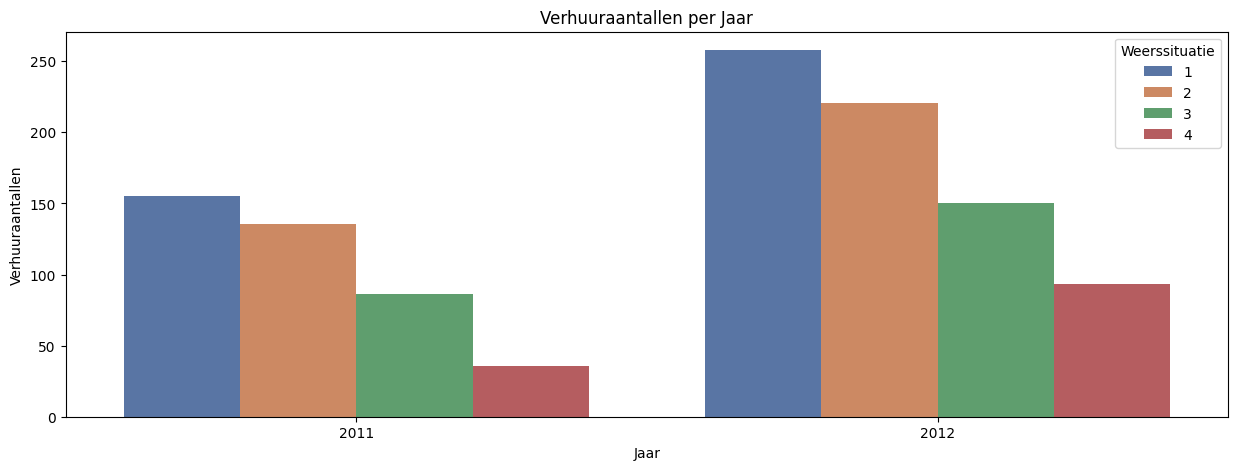

In [10]:
plt.subplots(figsize=(15, 5))
sns.barplot(data=df, x='Jaar', y='cnt',
            hue='weathersit', errorbar=None,
            palette='deep')

plt.title('Verhuuraantallen per Jaar')
plt.ylabel('Verhuuraantallen')
plt.legend(title='Weerssituatie')
plt.show()

Zoals hierboven te zien is, zijn er in 2012 meer verhuursaantallen. Ook is er heel duidelijk te zien dat er een duidelijk verschil is tussen de verschillende weersituaties. Dat de weersomstandigheden een grote invloed hebben is mogelijk als het te verhuren product gebruikt wordt zonder afdekking van regen of andere neerslag.

Bij een weerssituatie van klasse van 1 is er een algemeen hoger verhuur, dit neemt af naarmate je omhoog gaat op de schaal. Hieronder is verduidelijking over de schaal van deze kolom:

**weathersit**:
1. Helder, licht bewolkt, deels bewolkt
2. Mistig , mistig en licht bewolkt
3. Lichte sneeuw, lichte regen, lichte regen en onweer, zwaar bewolkt, lichte
regen en zwaar bewolkt
4. Zware regen, hagel, zware mist, sneeuw.

Voor verder onderzoek wordt er nu gekeken naar de verdeling van het verhuur per uur.

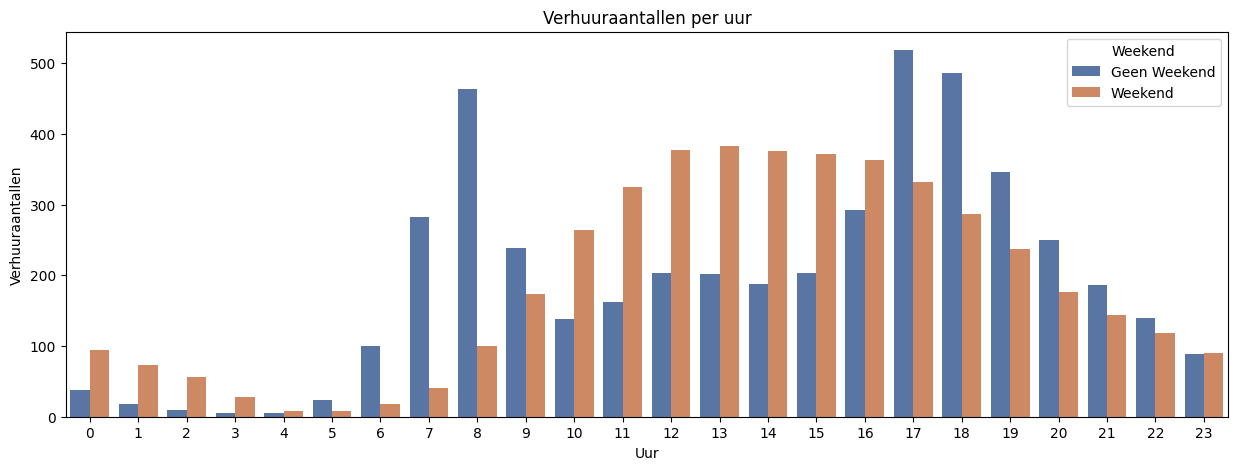

In [11]:
plt.subplots(figsize=(15, 5))
sns.barplot(data=df, x='Uur', y='cnt',
            hue='is_weekend', errorbar=None,
            palette='deep')

plt.title('Verhuuraantallen per uur')
plt.ylabel('Verhuuraantallen')
plt.legend(title='Weekend',
           labels=['Geen Weekend', 'Weekend'])
plt.show()

De grafiek over de verhuuraantallen per uur geeft ook een duidelijke boodschap. Rond de uren van 6 t/m 8 vindt er een sterke stijging plaats, wat niet heel raar is aangezien de meeste mensen tussen 6 en 8 wakker worden. Rond de uren van 17 en 18 is er ook een gigantische piek. Echter is dit alleen van maandag t/m vrijdag, dit zijn de algemene werkdagen. 

In de weekenden zit de hoogste piek rond het begin van de middag. Wat aan dit verschil ook opvalt is dat er in de daluren (behalve van 20 t/m 22) in het weekend altijd meer verhuur is. Terwijl in de spitsuren het juist drukker is op werkdagen.

Om iets meer inzicht te krijgen over het algemene verhuur gedrag zal deze grafiek nagemaakt worden met boxplots, om zo de verdeling en de outliers ook duidelijk te zien.

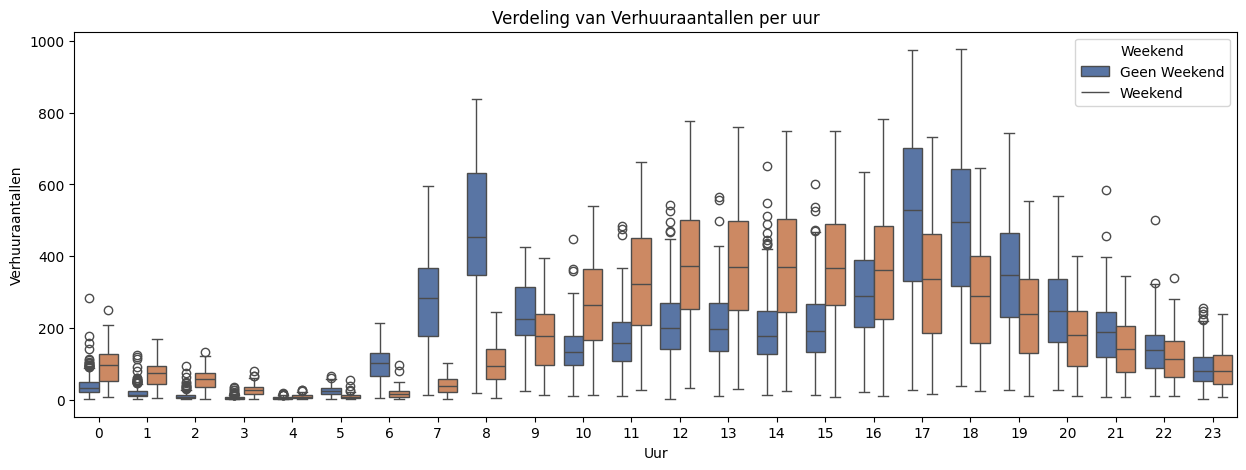

In [12]:
# Aanmaken van plotgrootte en boxplot
plt.subplots(figsize=(15, 5))
sns.boxplot(data=df, x='Uur', y='cnt',
            hue='is_weekend', palette='deep')

# Titel en tonen van de grafiek
plt.title(f'Verdeling van Verhuuraantallen per uur')
plt.ylabel('Verhuuraantallen')
plt.legend(title='Weekend',
           labels=['Geen Weekend', 'Weekend'])
plt.show()

Het voordeel aan boxplots is dat er per waarde op de x-as een verdeling wordt getoond. Deze verdeling laten zien waar het gemiddelde ligt en of er outliers aanwezig zijn. Wat opvalt is de afwezigheid van outliers in de drukste uren van het verhuren en dat outliers ook enigzins afhankelijk zijn van tijd en de weekdag. Verder is het ook opvallend dat er geen outliers zijn aan de onderkant van de boxplots.

-----------------

## **H2: Time-Series Analyses**

Omdat er met Time-Series data wordt gewerkt, is het nodig om deze verder te gaan onderzoeken. Hiervoor is eerst een nieuw dataframe nodig, waarin alleen de tijd en de verhuuraantallen staan.

In [13]:
# Aanmaken van nieuw DataFrame
df_time = df[['date_hour', 'cnt']]
df_time = df_time.set_index('date_hour')
df_time.head()

,cnt
date_hour,
2011-01-01 00:00:00,16
2011-01-01 01:00:00,40
2011-01-01 02:00:00,32
2011-01-01 03:00:00,13
2011-01-01 04:00:00,1


Nu het dataframe df_time is aangemaakt kan deze gebruikt worden voor verschillende time-series analyse technieken. Deze technieken worden gebruikt om patronen uit de tijds data te kunnen halen. Om hiermee te beginnen wordt het dataframe in een grafiek gezet.

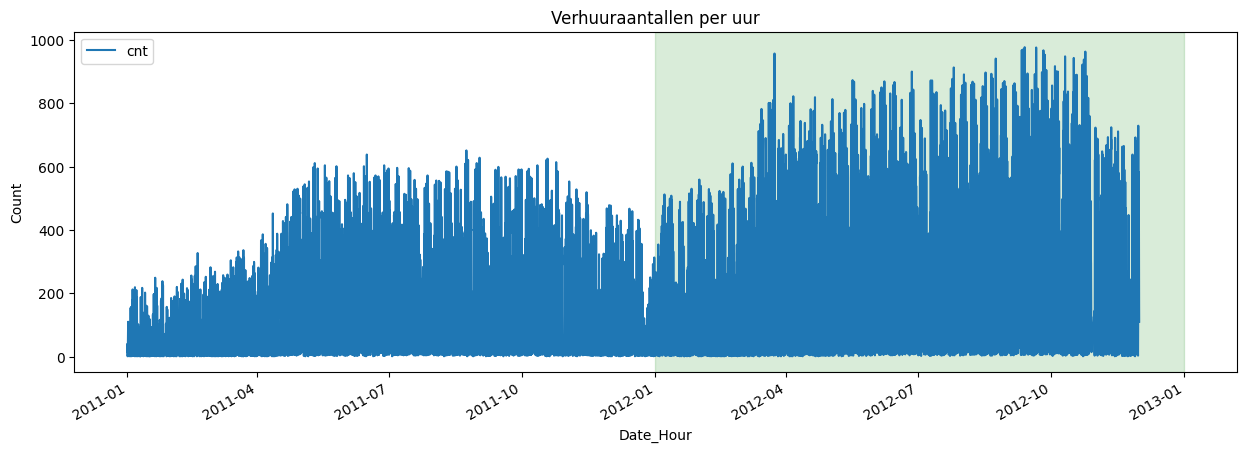

In [14]:
# Aanmaken van standaard plot
ax = df_time.plot(figsize=(15, 5))

# Toevoegen van shading om beter te zien waar 2012 begint
ax.axvspan('2012-01-01', '2013-01-01', color='green', alpha=0.15)

# Aanpassen van de plot labels en titel
ax.set_xlabel("Date_Hour")
ax.set_ylabel("Count")
ax.set_title("Verhuuraantallen per uur")

# Tonen van de plot
plt.show()

Zoals er te zien is, kan er geen duidelijkheid gehaald worden uit de huidige staat van de data. Om dieper te duiken in mogelijke seizoenspatronen zal er onderzoek naar worden gedaan met behulp van Fourier-analyse.

In [15]:
from scipy.fftpack import fft

values = df_time['cnt'].values
fft_result = fft(values)

n = len(fft_result)
frequencies = np.fft.fftfreq(n)
positive_frequencies = frequencies[:n // 2]
magnitude = np.abs(fft_result[:n // 2])

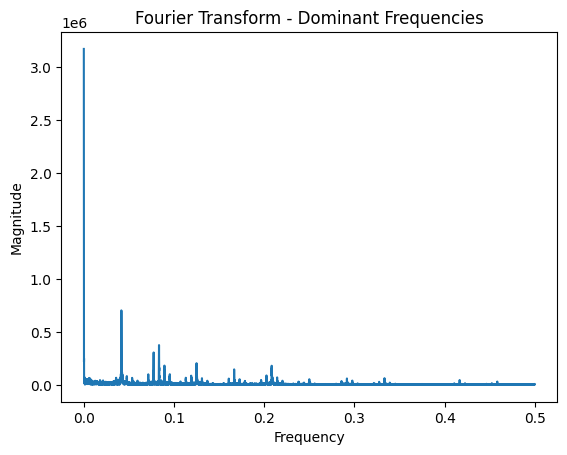

In [16]:
plt.plot(positive_frequencies, magnitude)
plt.title('Fourier Transform - Dominant Frequencies')
plt.xlabel('Frequency')
plt.ylabel('Magnitude')
plt.show()


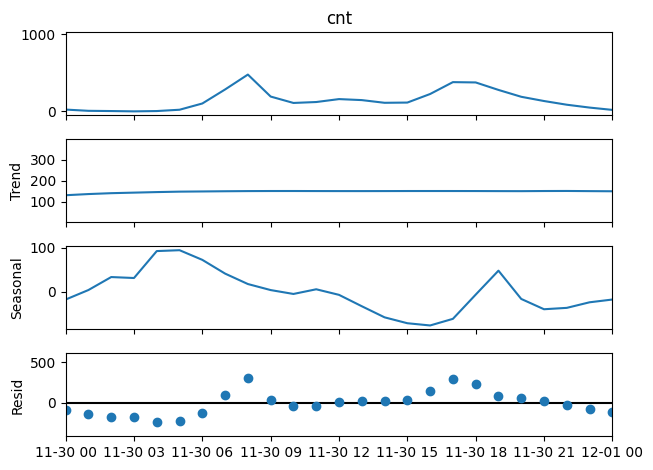

In [43]:
from statsmodels.tsa.seasonal import seasonal_decompose

result = seasonal_decompose(df_time['cnt'], model='additive', period=24)
result.plot()
plt.xlim('2011-11-30', '2011-12-01')
plt.show()


---------------

## **H3: Modelleren**

Tijdens deze stap gaat er gemodelleerd worden. Bij elk model zijn er ook tussenstappen waarbij features worden toegevoegd of verwijderd, om op deze manier de invloed van de features te kunnen beoordelen.

In [88]:
df_test = data_voorbereiding(data_test, 'date_hour')
df_test.drop('date_hour', axis=1, inplace=True)

In [19]:
from sklearn.ensemble import RandomForestRegressor
import datetime
from sklearn.metrics import mean_squared_error
from sklearn.model_selection import KFold
from sklearn.model_selection import GridSearchCV
from sklearn.model_selection import train_test_split
from sklearn.model_selection import TimeSeriesSplit

In [20]:
def submissie(model, suffix):
    """
    Deze functie maakt de voorspelling op de test dataset
    en vormt deze om tot een csv bestand om in te kunnen
    leveren op Kaggle.

    Parameters:
    ----------
    model : Machine Learning model
        De naam die is gegeven aan het ML-model dat
        wordt gebruikt om te voorspellen

    suffix : str
        De laatste 'tag' voor de naam van het csv
        bestand, zodat deze makkelijk te identificeren
        is na de submission.

    Returns:
    ----------
    None
        In plaats van een return maakt het een bestand
        aan in de map Kaggle Submissions. De namen zien
        er als volgt uit:

    """
    # Fitten, voorspellen en veranderen naar integer
    y_pred = model.fit(X_train, y_train).predict(df_test)
    y_pred = y_pred.astype(int)

    # Aanmaken df met alleen p_id en Outcome
    test_predictions_df = pd.DataFrame(
        {'date_hour': data_test['date_hour'],
        'cnt': y_pred})
    
    # Aanmaken van tijd
    tijd = datetime.datetime.now().strftime("%m%d%H%M%S")

    # Aanmaken csv bestand met timestamp
    test_predictions_df.to_csv(
        f'Kaggle Submissions/vs_{suffix}_{tijd}.csv',
        index=False)
    
    # print voor conformatie
    print(f'vs_{suffix}_{tijd}.csv has been saved!')

def model_score(model):
    """
    Een functie die de scores voor een model
    berekend en deze toont.

    Parameters:
    ----------
    model : elk ML model
    De naam van het gemaakte ML model

    Returns:
    ----------
    f1 : int
    De f1 score van het gegeven model
    """

    # Fitten en voorspellen met model
    y_pred = model.fit(X_train, y_train).predict(X_test)
    rmse = np.sqrt(mean_squared_error(y_test, y_pred))

    # Tonen van de resultaten
    return print(f'Root Mean Squared Error: {rmse}')

def grid_score(estimator, param_grid):
    """
    Een functie die de scores voor een grid search
    berekend en deze toont. Hierbij worden ook de
    optimale parameters getoont.

    Parameters:
    ----------
    estimator : ML model
    Het model waarop de grid search wordt toegepast

    param_grid : dict
    Een dictionary waarbij de keys parameter namen
    zijn van het model en de values verschillende
    waarden die de parameter aan kan nemen.

    Returns:
    ----------
    None
    Returned twee prints met de optimale parameters
    en beste f1 score
    """

    # Uitvoeren van de grid search
    gs = GridSearchCV(estimator=estimator,
                    param_grid=param_grid,
                    cv=cv,
                    scoring='neg_root_mean_squared_error',
                    n_jobs=-1)
    
    # Fitten van de grid search
    gs.fit(X_train, y_train)

    # Tonen van de beste score en parameters
    print(f"Beste RMSE: {abs(gs.best_score_)}")
    print(f"Beste parameters:\n{gs.best_params_}")

def feature_scan(model):
    """
    Een functie die een grafie met de feature importances kan maken.
    Dit werkt in ieder geval voor de RF en XGB modellen.

    Parameters:
    ----------
    model : ML-model
    Het model waarvan je de feature importances wilt tonen.

    Returns:
    ----------
    None
    Laat een grafiek zien met daarin de invloed van alle features.
    """
    # Aanmaken en sorteren invloed kolommen
    invloed = pd.Series(model.feature_importances_, index=X.columns)
    invloed = invloed.sort_values(ascending=True)

    # Plotten grafiek met invloed
    invloed.plot(kind='barh', figsize=(10, 6))
    plt.ylabel('Features')
    plt.xlabel('Invloed')
    plt.show()
    

In [124]:
# Aanmaken SEED voor random_state
SEED = 42

# Aanmaken van X en y
df_train = df.drop(['date_hour'], axis=1)
X = df_train.drop('cnt', axis=1)
y = df_train['cnt']

# Splitten van de data in train en test
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=456, random_state=SEED)

# Aanmaken van de folds
cv = TimeSeriesSplit(n_splits=5, test_size=456)

### **Random Forest Regressor**

Als __ keuze model is er gekozen om Random Forest te gaan gebruiken. Random forest begint met het aanmaken van meerdere decision tree modellen, die elk tegelijk gaan trainen en voorspellen. Deze methode heet ensemble learning, het gebruiken van verschillende of meerdere modellen om tot een voorspelling te komen. Bij een Random Forest wordt er enkel gebruik gemaakt van Decision Trees. Nadat elk van de trees een voorspelling heeft gemaakt, wordt uit die voorspellingen het gemiddelde berekent om zo tot een antwoord te komen op het regressie probleem.

Het aantal gebruikte features is bij een Random Forest afhankelijk van een hyper-parameter: max_features. Deze parameter zorgt ervoor dat er een limiet zit op de features, zodat het ensemble model niet te afhankelijk kan worden van een paar features. Ook niet alle data wordt bij elke tree ingezet, om te zorgen dat er een extra willekeur inzit om overfitting tegen te gaan. (Chakure, 2022)

Deze eigenschappen van Random Forest zijn waarom wij het model gaan gebruiken.

In [125]:
# Opstellen van Random Forest Regressor model
rf = RandomForestRegressor(random_state=SEED,
                              n_jobs=-1)

# Beoordelen van het model
model_score(rf)

Root Mean Squared Error: 33.29031536901417


In [126]:
param_rf = {
    'n_estimators': [50, 100, 200],
    'max_depth': [5, 10, 20],
    'min_samples_leaf': [1, 2, 4]
}

grid_score(rf, param_rf)

In [128]:
rf_tuned = RandomForestRegressor(n_estimators=50,
                           max_depth=20,
                           min_samples_leaf=1,
                           random_state=SEED,
                           n_jobs=-1)

model_score(rf_tuned)

Root Mean Squared Error: 33.811787637037796


Nu het getunede model van Random Forest is uitgevoerd, kan er gekeken worden naar de verschillende feature importances. Een grafiek met deze data geeft aan welke kolommen invloed hebben en hoe sterk de invloed is.

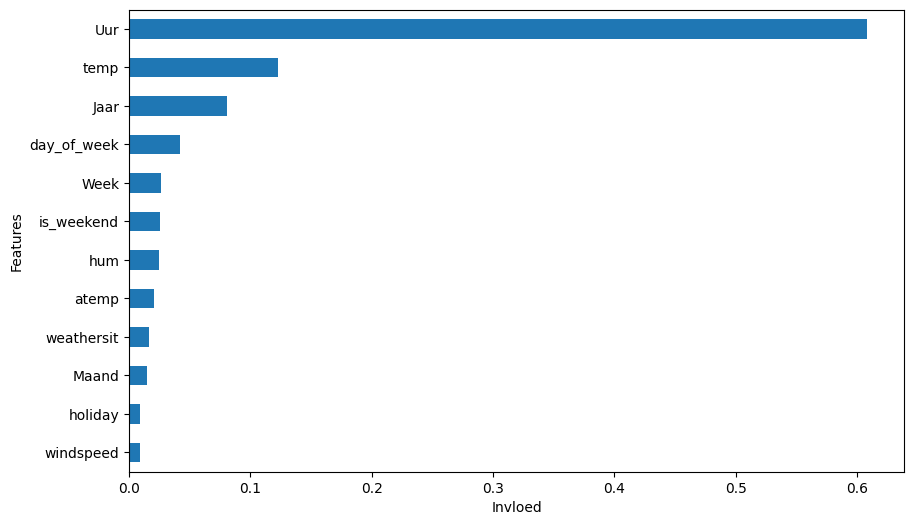

In [129]:
feature_scan(rf_tuned)

In [58]:
#submissie(rf_tuned, 'RF_2fa')

vs_RF_2fa_1115145332.csv has been saved!


De bovenstaande grafiek toont dat, voor het maken van een random forest voorspelling, de waarden van uur en temperatuur het belangrijkste zijn. De kolom holiday heeft duidelijk het minste invloed op de voorspelling. Verder is uur duidelijk de waarde waarop het model haar voorspellingen het meest heeft gebaseerd. In de EDA was er ook duidelijk te zien dat het uur van de dag grote invloed had op de verhuuraantallen, dus dat het model hier voor heeft gekozen is logisch.

### **XGBoost**

Als __ keuze model is er gekozen om gebruik te maken van XGBoost Regressor. Dit model heeft enkele voordelen die er toe hebben geleid om dit model te kiezen. Volgens Kumar (2019) is een van de voordelen de regularisatie van een XGBoost model. Dit model bevat zowel Lasso (L1) als Ridge (L2) regularisatie, wat ervoor zorgt dat het model moeilijker overfit. Via de Scikit Learn libary is het mogelijk om verschillende waarden, als hyperparameters, toe te voegen aan het model. De parameter alpha is voor L1 regularisatie en de parameter lambda is voor L2 regularisatie.

Een ander voordeel is de manier waarop het model pruning toepast. Bij een XGBoost model worden de bomen pas aan het einde van het model gepruned. Dit zorgt ervoor dat als er een enkele split met een negative loss voorkomt, het model niet de tak daar laat stoppen. Het model zal eerst doorgaan tot de aangegeven max_depth voordat deze gaat prunen. (Kumar, 2019)

Daarnaast is een ander groot voordeel dat XGBoost een parallel lopende ensemble is. Dit betekent dat de bomen tegelijkertijd kunnen worden opgebouwd, in tegen stelling to achtereenvolgend. Dit zorgt voornamelijk in een kortere run time bij het trainen van het model. (Hanchman, 2023)

Als eerste stap trainen we een model met enkel de standaard parameters.

In [131]:
from xgboost import XGBRegressor
xgb = XGBRegressor(n_jobs=-1,
                   random_state=SEED)

model_score(xgb)

Root Mean Squared Error: 34.03833317668675


Nu zal er een parameter grid aangemaakt worden voor een Grid Search CV, om zo de optimale hyperparameters te kunnen bepalen.

In [132]:
param_grid = {
    'n_estimators': [100, 200, 300],
    'learning_rate': [0.01, 0.1, 1.0],
    'max_depth': [5, 10, 20],
    'reg_alpha': [0, 1, 2],
    'reg_lambda': [0, 1, 2]
}

# grid_score(xgb, param_grid)

Nu deze parameters bekend zijn, kunnen deze worden ingevoerd in het model. Op deze manier zal het model beter presteren.

In [133]:
xgb_tuned = XGBRegressor(n_estimators=300,
                         learning_rate=0.1,
                         max_depth=10,
                         reg_alpha=2,
                         reg_lambda=2,
                         random_state=SEED,
                         n_jobs=-1)

model_score(xgb_tuned)

Root Mean Squared Error: 29.687010658319874


Ook bij XGBoosting zal worden gekeken naar de feature importance.

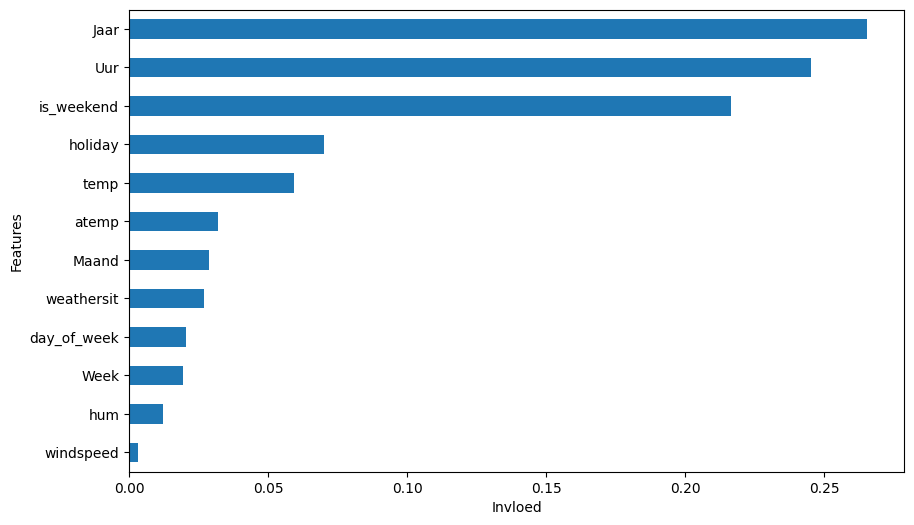

In [134]:
feature_scan(xgb_tuned)

De bovenstaande grafiek toont dat, voor het maken van een XGBoost voorspelling, de waarden van uur en jaar het belangrijkste zijn. De kolom windspeed heeft het minste invloed op de voorspelling. De waarden van uur en jaar liggen dichtbij elkaar qua invloed. Wat bij deze grafiek ook duidelijk is te zien, is dat alle waarden iets hoger liggen dan bij random forest.

In [62]:
#submissie(xgb_tuned, 'XGB_2fa')

vs_XGB_2fa_1115145355.csv has been saved!


### **Hybride model**

Hybride Machine Learning is het gebruiken van meerdere modellen om te zorgen voor een betere voorspelling. Vaak wordt er een combinatie gebruikt van een simpel (bijvoorbeeld Lineare Regressie) en een meer complex (bijvoorbeeld Random Forest) model (Holbrook, 2023). Tijdens het uitvoeren van de code worden de nodige stappen voor het model uitgelegd.

Om te beginnen met de code zal het eerste model, Linear Regression, de voorspellingen maken.

In [135]:
from sklearn.linear_model import LinearRegression

# Eerste model: Lineaire Regressie
lr_hm = LinearRegression(n_jobs=-1).fit(X_train, y_train)

# Voorspellen van de waarden voor train en test
y_pred_lr = lr_hm.predict(X_train)
pred_test = lr_hm.predict(X_test)

Nu de eerste voorspellingen zijn gemaakt, kan het tweede model aan de slag gaan. Bij een hybride model werkt dit anders dan bij een ensemble model. Waar er bij een ensemble gebruikt wordt gemaakt van het gemiddelde van de voorspellingen, zal een hybride model gebruik maken van de residuals van het eerste model.

In [136]:
# Berekenen van de residuals
residuals = y_train - y_pred_lr

Deze nieuwe variabele bevat het verschil tussen de werkelijke waarden en de voorspelde waarden. Het tweede model zal deze verschillen proberen te voorspellen, om deze vervolgens bij de andere voorspellingen op te kunnen tellen. Dit tweede model, XGBoost, zal dus aan de hand van de residuals gaan voorspellen wat de verschillen zullen zijn tussen de twee waarden.

In [137]:
# Tweede model: XGBoost Regressor
xgb_hm = XGBRegressor(n_estimators=300,
                         learning_rate=0.1,
                         max_depth=10,
                         reg_alpha=2,
                         reg_lambda=2,
                         random_state=SEED,
                         n_jobs=-1).fit(X_train, residuals)

# Voorspellen van de residuals
y_pred_xgb = xgb_hm.predict(X_test)

Nu de verschillen zijn voorspeld kunnen deze bij de voorspelde waarden worden gevoegd. Op deze manier komen we bij de daadwerkelijke voorspelling komen van het hybride model.

In [139]:
# Samenvoegen van voorspellingen
pred = np.round(pred_test + y_pred_xgb).astype(int)

# Evalueren van hybride model
mse = mean_squared_error(y_test, pred)
print(f'Root Mean Squared Error: {np.sqrt(mse)}')

Root Mean Squared Errpr: 32.043863851388394


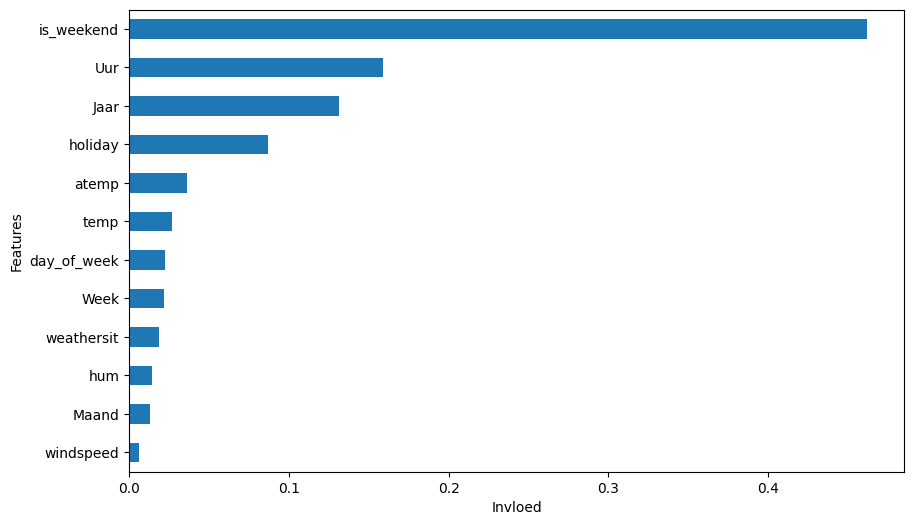

In [142]:
feature_scan(xgb_hm)

Nu de feature importances bekeken zijn en de RMSE is berekend kunnen de waarden omgezet worden tot een dataframe die ingeleverd kan worden op kaggle. Deze code is gebaseerd op de code uit de submissie functie, echter was het niet mogelijk om de functie te gebruiken zonder deze om te bouwen. Om dit te voorkomen is de code hieronder herhaald.

In [141]:
# Voorspellen op df_test
lr_test = lr_hm.predict(df_test)
xgb_test = xgb_hm.predict(df_test)

# Samenvoegen voorspelling
y_pred = np.round(lr_test + xgb_test).astype(int)

# Aanmaken df met alleen p_id en Outcome
test_predictions_df = pd.DataFrame(
        {'date_hour': data_test['date_hour'],
        'cnt': abs(y_pred)})

# Aanmaken van tijd
tijd = datetime.datetime.now().strftime("%m%d%H%M%S")

# Aanmaken csv bestand met timestamp
test_predictions_df.to_csv(
        f'Kaggle Submissions/vs_HML_try_{tijd}.csv',
        index=False)

# print voor conformatie
print(f'vs_HML_try_{tijd}.csv has been saved!')

vs_HML_try_1115154126.csv has been saved!


## **BRONNEN**

**Random Forest**:
- Chakure, A. (2022, March 7). Random forest regression in Python explained. Built In. https://builtin.com/data-science/random-forest-python

**XGBoost**:
- Kumar, N. (9 maart 2019). Advantages of XGBOOST Algorithm in Machine Learning. http://theprofessionalspoint.blogspot.com/2019/03/advantages-of-xgboost-algorithm-in.html
- Hachcham, A. (2023, August 11). XGBoost: Everything you need to know. neptune.ai. https://neptune.ai/blog/xgboost-everything-you-need-to-know

**Hybride Model**:
- Holbrook, R. (2023, April 20). Hybrid models. Kaggle. https://www.kaggle.com/code/ryanholbrook/hybrid-models

In [68]:
from sklearn.ensemble import VotingRegressor
# Create the hybrid model using VotingRegressor
hybrid_model = VotingRegressor(estimators=[('random_forest', rf_tuned), ('xgboost', xgb_tuned)])

# Fit the hybrid model to the training data
hybrid_model.fit(X_train, y_train)

# Predict on the test set
y_pred = hybrid_model.predict(X_test)

# Evaluate the hybrid model
mse = mean_squared_error(y_test, y_pred)
print(f'Root Mean Squared Error: {np.sqrt(mse)}')

Root Mean Squared Error: 30.080120198135823
